In [1]:

import torch.nn.functional as F
from torch import cuda
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import math
import os
import copy
import timm 


In [3]:
# Data augmentation and normalization for training
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = '/storage_labs/3030/BelyakovM/FaceMask_presence/ds'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=64,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [4]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

## Further we are going to test how fast MicroNet(C-EfficientNet) modification infers on our simple task

In [5]:
#Model building blocks
class HSwish(nn.Module):
    """
    H-Swish activation function from 'Searching for MobileNetV3,' https://arxiv.org/abs/1905.02244.
    Parameters:
    ----------
    inplace : bool
        Whether to use inplace version of the module.
    """
    def __init__(self, inplace=True):
        super(HSwish, self).__init__()
        self.inplace = inplace
        self.relu = nn.ReLU6(inplace = self.inplace)

    def forward(self, x):
        return x * self.relu(x + 3.0) / 6.0

class MicroBlock(nn.Module):
    '''expand + depthwise + pointwise
    Activation : ReLU or HSwish
    
    '''
    def __init__(self, in_planes, out_planes, expansion, stride, device, add_se = False, Activation = 'ReLU'):
        super(MicroBlock, self).__init__()
        self.out_planes = out_planes
        self.stride = stride
        planes = int(expansion * in_planes)
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=1, stride=1, padding=0, bias=False)
        self.bn1 = nn.BatchNorm2d(planes, momentum=0.01)
        if self.stride ==1:
            self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride, padding=1, groups=planes, bias=False)
        if self.stride ==2:
            self.conv2 = nn.Conv2d(planes, planes, kernel_size=5, stride=stride, padding=2, groups=planes, bias=False)
        self.bn2 = nn.BatchNorm2d(planes, momentum=0.01)
        self.conv3 = nn.Conv2d(planes, out_planes, kernel_size=1, stride=1, padding=0, bias=False)
        self.bn3 = nn.BatchNorm2d(out_planes, momentum=0.01)
        self.add_se = add_se
        
        if Activation == 'HSwish':
            self.act1 = HSwish()
            self.act2 = HSwish()
            if self.add_se:
                self.act_se = HSwish()
        else:
            self.act1 = nn.ReLU()
            self.act2 = nn.ReLU()
            if self.add_se:
                self.act_se = nn.ReLU()
            
        self.shortcut = nn.Sequential()
        if stride == 1 and in_planes != out_planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=1, padding=0, bias=False),
                nn.BatchNorm2d(out_planes, momentum=0.01)
            )
        
        # SE layers
        
        if self.add_se:
            self.avg_se = nn.AdaptiveAvgPool2d(1)
            number = int(out_planes*0.25)
            self.fc1 = nn.Conv2d(out_planes, number, kernel_size=1, bias=False)
            self.fc2 = nn.Conv2d(number, out_planes, kernel_size=1, bias=False)
            self.sigmoid = nn.Sigmoid()
            
        

    def forward(self, x):
        out = self.act1(self.bn1(self.conv1(x)))
        out = self.conv2(out)
        out = self.act2(self.bn2(out))
        out = self.bn3(self.conv3(out))
        
        # Squeeze-Excitation
        if self.add_se:
            w = self.avg_se(out)
            w = self.act_se(self.fc1(w))
            w = self.sigmoid(self.fc2(w))
            
            out = out * w + self.shortcut(x) if self.stride==1 else out
            return out
        
        out = out + self.shortcut(x) if self.stride==1 else out
        return out


class MicroNet_imagenet(nn.Module):
    # (expansion, out_planes, num_blocks, stride)
    def __init__(self, num_classes=1000, wide_factor = 1, depth_factor =1, add_se = True, Activation = 'HSwish'):
        super(MicroNet_imagenet, self).__init__()
        # NOTE: change conv1 stride 2 -> 1 for CIFAR10
        '''
        wide_factor: ratio to expand channel
        depth_factor: ratio to expand depth
        '''
        self.cfg = [[1, 16, 2, 1],
                    [3, 24, 1, 2],
                    [3, 24, 2, 1],
                    [3, 40, 1, 2],
                    [3, 40, 2, 1],
                    [3, 80, 1, 2],
                    [3, 80, 2, 1],
                    [3, 96, 2, 1],
                    [3, 192, 1, 2],
                    [3, 192, 3, 1],
                    [3, 320, 1, 1]]

        #reconstruct structure config
        self.change_cfg(wide_factor, depth_factor)
        #make train recipe
        self.set_config(batch_size = 128, momentum = 0.9, lr = 0.1, num_epochs =200, criterion = nn.CrossEntropyLoss(), weight_decay = 1e-5, gamma = 0.1, milestones = [100, 150], device = 'cuda:0' if cuda.is_available() else 'cpu', nesterov = True)
        
        #construct network
        self.add_se = add_se
        self.Activation = Activation
        self.input_channel = 32
        self.last_channel = 640
        self.num_classes = num_classes
        self.conv1 = nn.Conv2d(3, self.input_channel, kernel_size=3, stride=2, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(self.input_channel, momentum=0.01)
        self.layers = self._make_layers(in_planes=self.input_channel)
        
        self.last_conv = nn.Conv2d(self.cfg[-1][1], self.last_channel, kernel_size=1, stride=1, padding=0, bias=False)
        self.avg = nn.AdaptiveAvgPool2d(1)
        self.dropout = nn.Dropout(p=0.3)
        self.linear = nn.Linear(self.last_channel, self.num_classes)
        
        if self.Activation == 'HSwish':
            self.stem_act = HSwish()
        else:
            self.stem_act = nn.ReLU()
        
        #initialize the parameters
        self.reset_parameters()
        
        #initialize the parameters
        self.reset_custom_parameters()
        
        
    def reset_parameters(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))
                if m.bias is not None:
                    m.bias.data.zero_()
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()
            elif isinstance(m, nn.Linear):
                n = m.weight.size(1)
                m.weight.data.normal_(0, 0.01)
                m.bias.data.zero_()
                
    def reset_custom_parameters(self):
        for name, module in self.named_children():
            if 'layer' in name:
                if 'conv1' in name:
                    n = module.shape[0]
                    module.data.normal_(0, 0.73 * math.sqrt(2. / n))
                elif 'conv2' in name:
                    n = module.shape[0]
                    module.data.normal_(0, 9.37 * math.sqrt(2. / n))
                elif 'conv3' in name:
                    n = module.shape[0]
                    module.data.normal_(0, 0.55 * math.sqrt(2. / n))
                    
    def _make_layers(self, in_planes):
        layers = []
        for expansion, out_planes, num_blocks, stride in self.cfg:
            strides = [stride] + [1]*(num_blocks-1)
            for stride in strides:
                layers.append(MicroBlock(in_planes, out_planes, expansion, stride, self.device, self.add_se, self.Activation))
                in_planes = out_planes
        return nn.Sequential(*layers)
    
    def change_cfg(self, wide_factor, depth_factor):
        for i in range(len(self.cfg)):
            self.cfg[i][1] = int(self.cfg[i][1] * wide_factor)
            if self.cfg[i][3] ==1:
                self.cfg[i][2] = int(self.cfg[i][2] * depth_factor)
    
    
    def set_config(self, batch_size, momentum, lr, num_epochs, device, weight_decay, gamma = 0.1, milestones = [100,150], nesterov = True, criterion = nn.CrossEntropyLoss()):
        self.batch_size = batch_size
        self.momentum = momentum
        self.lr = lr
        self.num_epochs = num_epochs
        self.criterion = criterion
        self.weight_decay = weight_decay
        self.gamma = gamma
        self.milestones = milestones
        self.device = device
        self.nesterov = nesterov
        
    def forward(self, x):
        out = self.stem_act(self.bn1(self.conv1(x)))
        out = self.layers(out)
        out = self.last_conv(out)
        out = self.avg(out)
        out = out.view(out.size(0), -1)
        out = self.linear(self.dropout(out))
            
        return out

## The model's pretrained weights aren't available, but data isn't scarce. So it follows that quite a number of epochs are reqiured to fine-tune the model

In [6]:
#Model initialization
model_ft = MicroNet_imagenet(num_classes = 2)




model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [7]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=10)

Epoch 0/9
----------
train Loss: 0.3281 Acc: 0.8575
val Loss: 0.2312 Acc: 0.9053

Epoch 1/9
----------
train Loss: 0.2138 Acc: 0.9112
val Loss: 0.1556 Acc: 0.9466

Epoch 2/9
----------
train Loss: 0.1842 Acc: 0.9232
val Loss: 0.1991 Acc: 0.9238

Epoch 3/9
----------
train Loss: 0.1669 Acc: 0.9305
val Loss: 0.1273 Acc: 0.9539

Epoch 4/9
----------
train Loss: 0.1552 Acc: 0.9349
val Loss: 0.1062 Acc: 0.9592

Epoch 5/9
----------
train Loss: 0.1457 Acc: 0.9388
val Loss: 0.0701 Acc: 0.9784

Epoch 6/9
----------
train Loss: 0.1417 Acc: 0.9398
val Loss: 0.0723 Acc: 0.9758

Epoch 7/9
----------
train Loss: 0.1256 Acc: 0.9476
val Loss: 0.0657 Acc: 0.9787

Epoch 8/9
----------
train Loss: 0.1239 Acc: 0.9468
val Loss: 0.0662 Acc: 0.9781

Epoch 9/9
----------
train Loss: 0.1240 Acc: 0.9480
val Loss: 0.0645 Acc: 0.9776

Training complete in 25m 53s
Best val Acc: 0.978651


## Let's visualize a few model val predictions

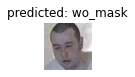

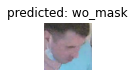

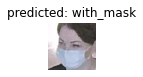

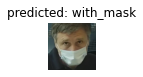

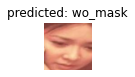

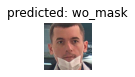

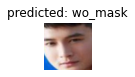

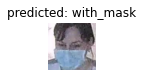

In [10]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated




num_images = 8
was_training = model_ft.training
model_ft.eval()
images_counter = 0
fig = plt.figure()
with torch.no_grad():
    for i, (inputs, labels) in enumerate(dataloaders['val']):
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model_ft(inputs)
        _, preds = torch.max(outputs, 1)

        for j in range(inputs.size()[0]):
            images_counter += 1
            ax = plt.subplot(num_images//2, 2, images_counter)
            ax.axis('off')
            ax.set_title('predicted: {}'.format(class_names[preds[j]]))
            imshow(inputs.cpu().data[j])

            if images_counter == num_images:
                model_ft.train(mode=was_training)
                break
        model_ft.train(mode=was_training)
        if images_counter == num_images:
            break

### Let's find out how fast the model is going to work during inference on gpu

In [11]:
#inference time estiamtion
from utils import get_time_my
get_time_dima('C-EfficentNet_net',model_ft,224,224,device)

C-EfficentNet_net 18.967240352630615  224_224


18.967240352630615

In [13]:
# Model conversion to onnx format
dummy = torch.randn(10, 3, 224, 224, device='cuda')
input_names = [ "actual_input_1" ] 
output_names = [ "output1" ]
torch.onnx.export(model_ft, dummy, "FaceMask_C-EfficientNet_x1.1_224.onnx", verbose=False, input_names=input_names, output_names=output_names,export_params=True)